# Examples taken from the Elements of SMC paper

In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax.scipy.stats import norm

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

$\newcommand{\normal}[3]{{ \mathcal{N}\left(#1 \vert #2, #3\right) }}$

We model a non-Markovian Gaussian sequence model as follows

$$
\begin{aligned}
    p(x_t \vert x_{t-1}) &= \normal{x_t}{\phi x_{t-1}}{q} \\
    p(y_t \vert x_{1:t}) &= \normal{y_t}{\sum_{k=1}^t \beta^{t-k}}{r}
\end{aligned}
$$

In [78]:
class NonMarkovianSM:
    """
    Non-Markovian Gaussian Sequence Model
    """
    def __init__(self, phi, beta, q, r):
        self.phi = phi
        self.beta = beta
        self.q = q
        self.r = r
    
    def sample_latent_step(self, key, x_prev):
        x_next = jax.random.normal(key) * jnp.sqrt(self.q) + self.phi * x_prev
        return x_next
    
    def sample_observed_step(self, key, varphi, x_curr):
        varphi_next = beta * varphi + x_curr
        y_curr = jax.random.normal(key) * jnp.sqrt(self.r) + varphi_next
        return y_curr, varphi_next
    
    def sample_step(self, key, x_prev, varphi_prev):
        key_latent, key_obs = jax.random.split(key)
        x_curr = self.sample_latent_step(key_latent, x_prev)
        y_curr, varphi = self.sample_observed_step(key_obs, varphi_prev, x_curr)
        
        carry_vals = {"x": x_curr, "y": y_curr}
        return (x_curr, varphi), carry_vals
    
    def sample_single(self, key, nsteps):
        key_init, key_simul = jax.random.split(key)
        x_init = jax.random.normal(key_init) * jnp.sqrt(self.q)
        varphi_init = 0
        
        keys = jax.random.split(key_simul, nsteps)    
        carry_init = (x_init, varphi_init)
        _, hist = jax.lax.scan(lambda carry, key: self.sample_step(key, *carry), carry_init, keys)
        return hist
    
    def sample(self, key, nsteps, nsims=1):        
        key_simulations = jax.random.split(key, nsims)
        sample_vmap = jax.vmap(self.sample_single, (0, None))
        return sample_vmap(key_simulations, nsteps)

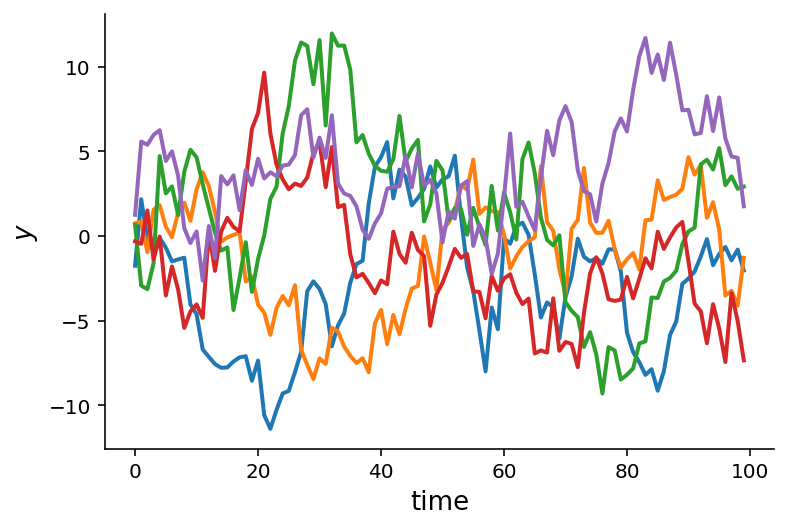

In [88]:
key = jax.random.PRNGKey(3141)

phi, q, beta, r = 0.9, 1.0, 0.5, 1.0
seq_model = NonMarkovianSM(phi, beta, q, r)

hist = seq_model.sample(key, 100, 5)

for sample in hist["y"]:
    plt.plot(sample, linewidth=2)
plt.xlabel("time", fontsize=13)
plt.ylabel("$y$", fontsize=13);